# About

This notebook is written to restore main spatial analyzing code snippets related to artcle \<The spatial atlas of cholestatic injury and repair in mice\>

Last edit at : 2023-12-12

Author: Xinyi Shentu

In [43]:
# Required packages
library("dplyr")
library("Seurat")
library("ggplot2")
library("patchwork")

Sys.setenv(TZ="Asia/Shanghai")

In [45]:
# Load spatial data
sp <- readRDS("CIRSTA_spatial.rds")

In [48]:
head(sp, 3)

sample      time mouse slide rank x y  nCount_RNA
0D-M1-1_DY1_115_162 0D-M1-1_DY1 D0   M1    DY1   5    0 93 1297      
0D-M1-1_DY1_115_163 0D-M1-1_DY1 D0   M1    DY1   4    0 94 2471      
0D-M1-1_DY1_115_164 0D-M1-1_DY1 D0   M1    DY1   2    0 95 2883      
                    nFeature_RNA percent.mt ⋯ LyEC         Cholangiocyte
0D-M1-1_DY1_115_162 545          1.310717   ⋯ -0.009364143 -0.007312444 
0D-M1-1_DY1_115_163 870          1.618778   ⋯  0.137814781 -0.010937723 
0D-M1-1_DY1_115_164 974          2.289282   ⋯ -0.002824674 -0.027229296 
                    Hep         LPLC        DAMP         Oxidative_stress
0D-M1-1_DY1_115_162  1.18338553  0.41060591  0.044967600 -0.1708224      
0D-M1-1_DY1_115_163  1.41179080 -0.04357846  0.007131598 -0.2464057      
0D-M1-1_DY1_115_164 -0.05083712 -0.27326331 -0.066227708 -0.3744430      
                    Cellular_senescence DNA_damage   Inflammation 
0D-M1-1_DY1_115_162  0.08145531          0.108160503 -0.0396332346
0D-M1-1_DY1_115_163 -0.03828156         -0.008731979 -0.0002335731
0D-M1-1_DY1_115_164 -0.02895447         -0.039003991 -0.0124517180
                    ECM_organization
0D-M1-1_DY1_115_162  0.00596491     
0D-M1-1_DY1_115_163 -0.02089874     
0D-M1-1_DY1_115_164  0.01624869

In [46]:
representative_slides <- c("DY1", "FR8", "FS1", "FS4", "FS5", "GD4")

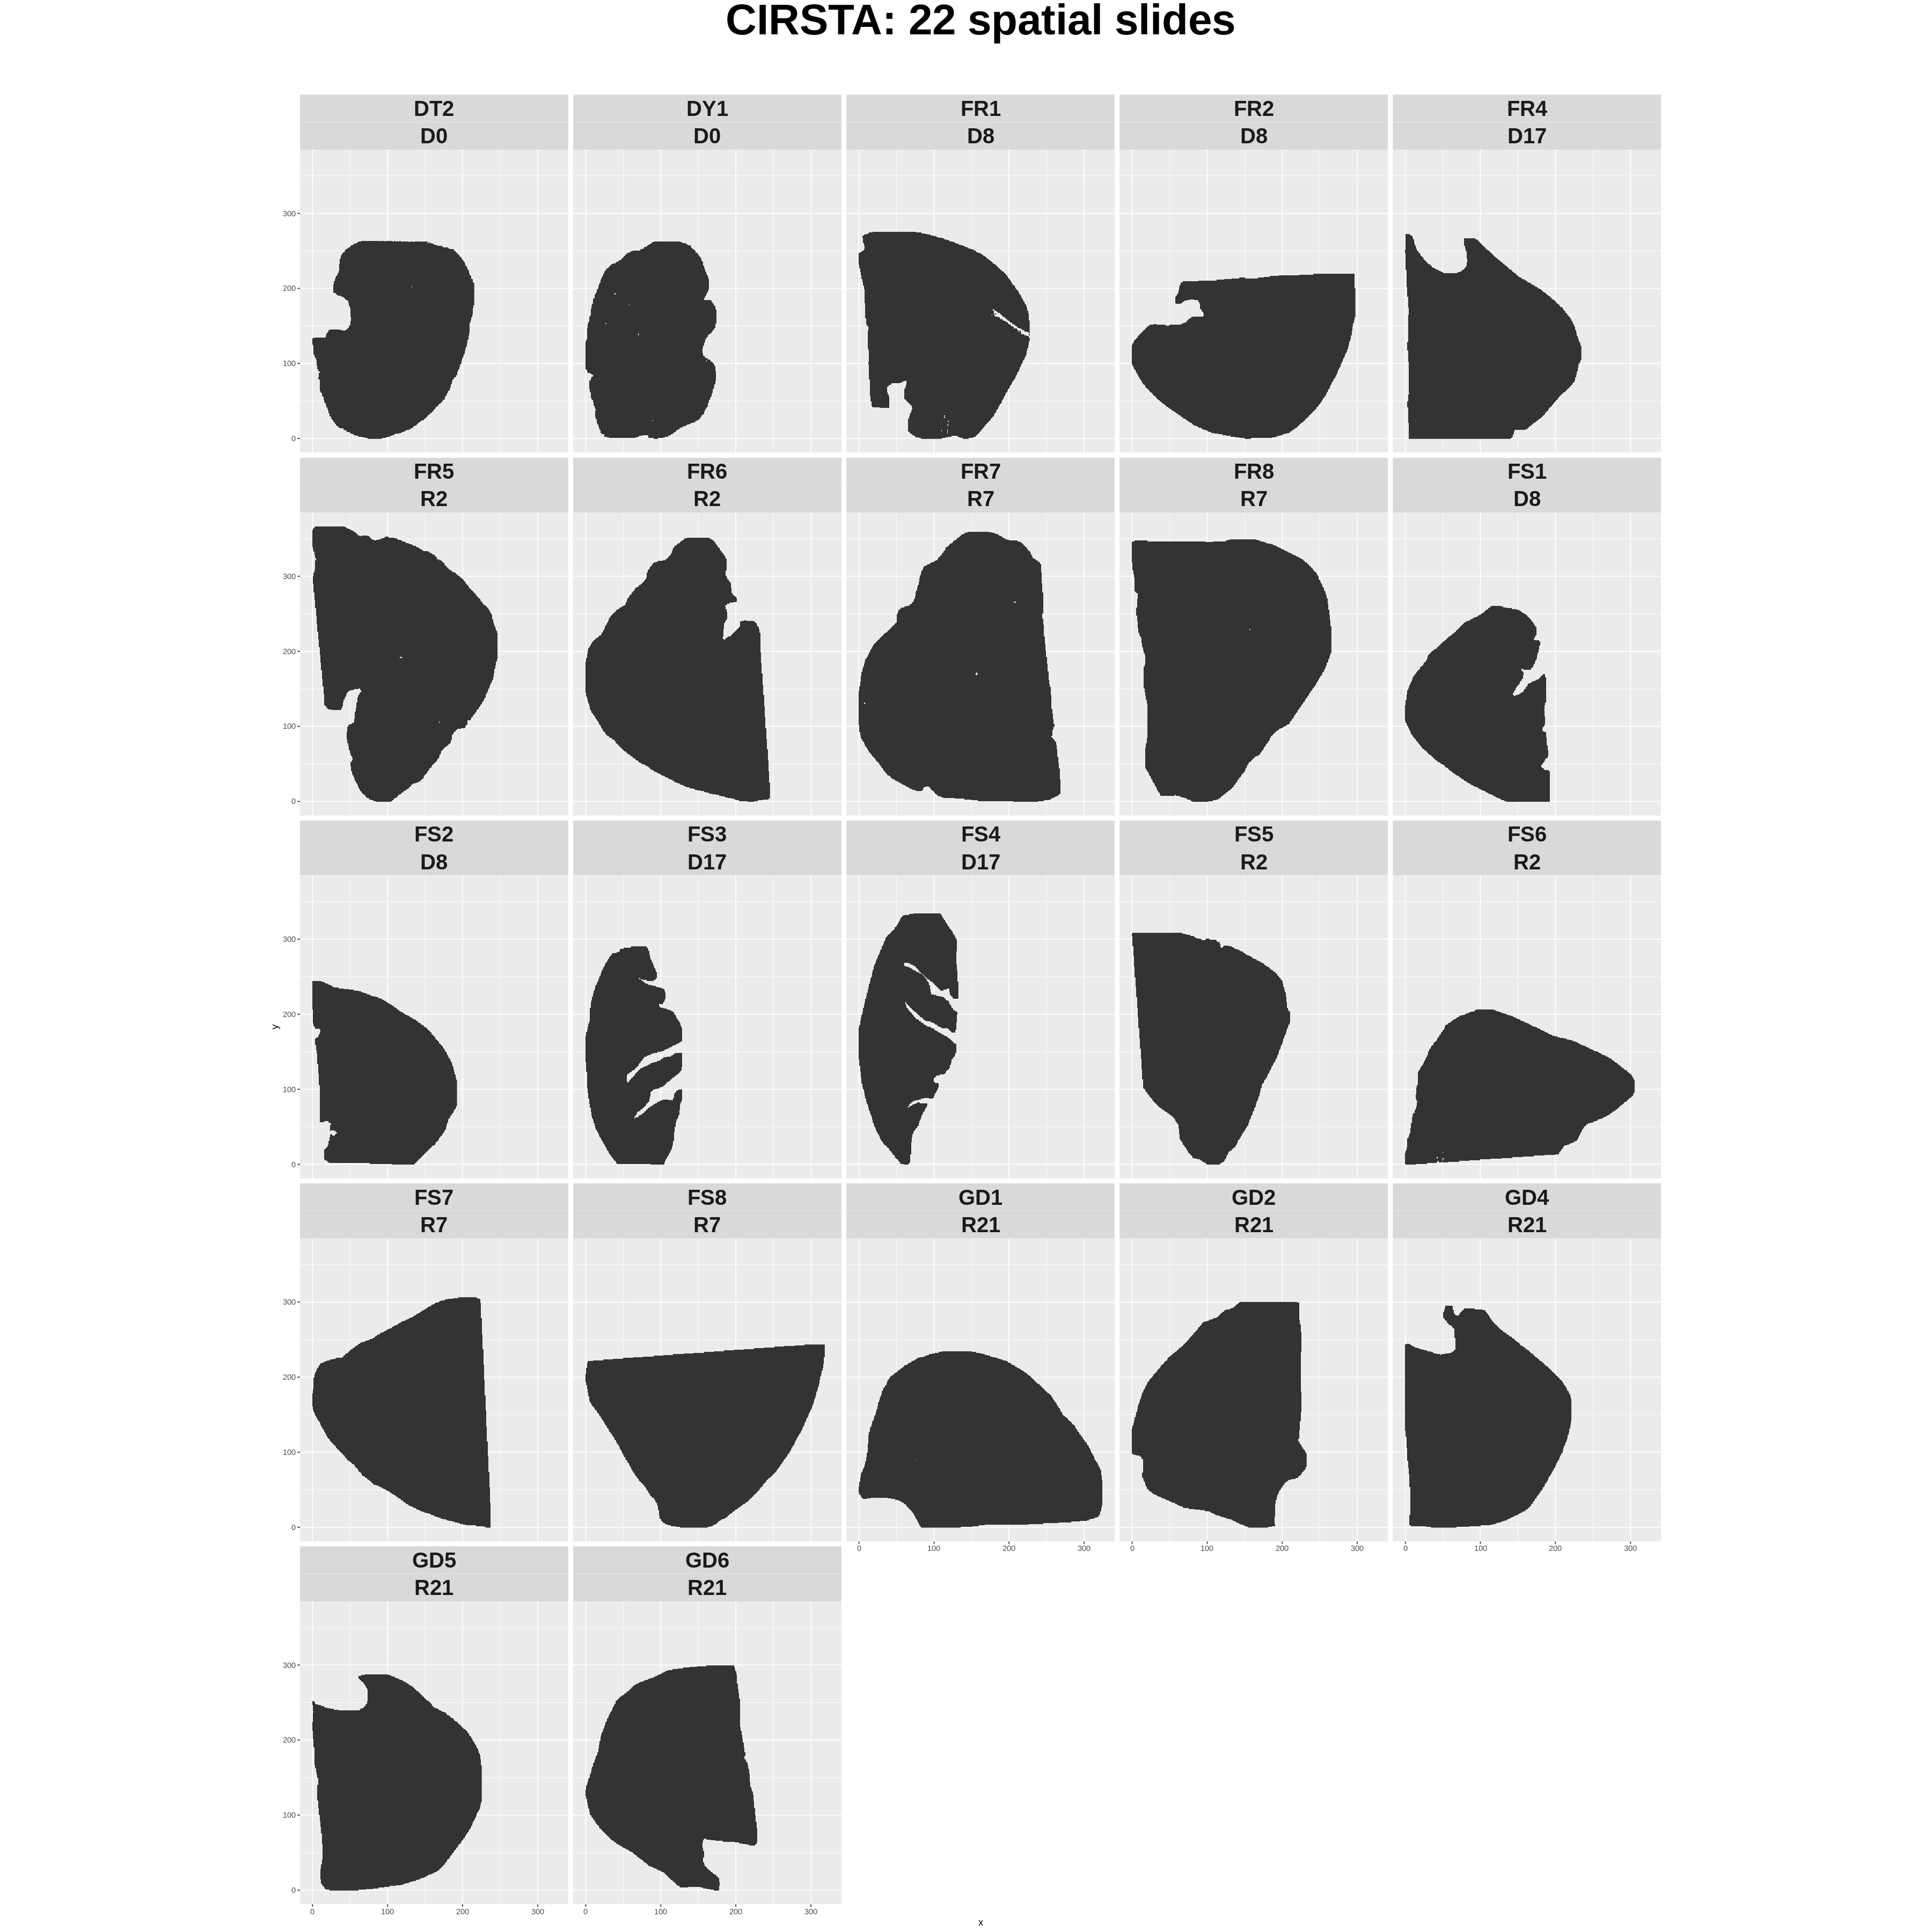

In [34]:
options(repr.plot.width = 5*6, repr.plot.height = 5*6)
ggplot(data = sp@meta.data, aes(x, y)) +
geom_raster() +
coord_fixed() +
facet_wrap(~slide+time) +
labs(title = "CIRSTA: 22 spatial slides\n") +
theme(
    plot.title = element_text(size = 48, hjust = 1/2.0, face = "bold"), 
    strip.text = element_text(size = 24, hjust = 1/2.0, face = "bold")
     )

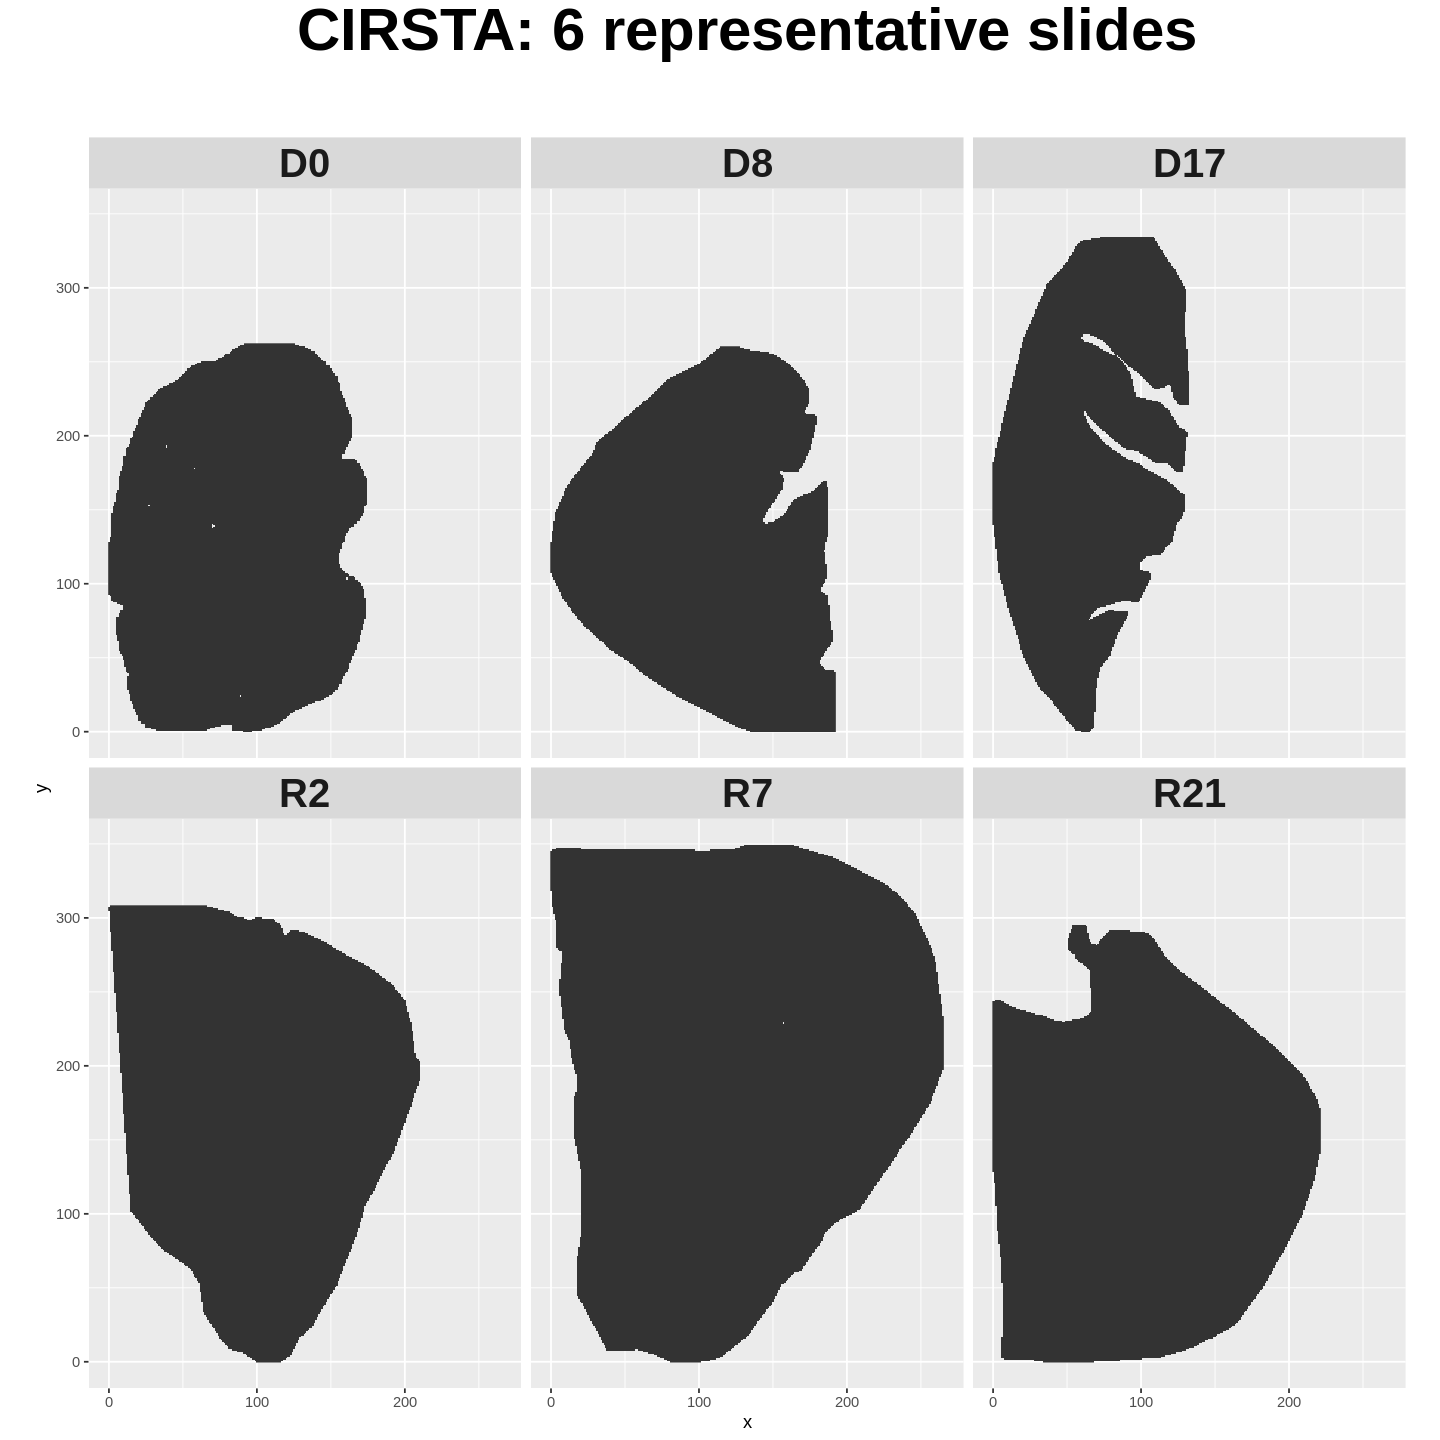

In [83]:
options(repr.plot.width = 2*6, repr.plot.height = 2*6)
ggplot(data = filter( sp@meta.data, slide %in% representative_slides), aes(x, y)) +
geom_raster() +
coord_fixed() +
facet_wrap(~time) +
labs(title = "CIRSTA: 6 representative slides\n") +
theme(
    plot.title = element_text(size = 36, hjust = 1/2.0, face = "bold"), 
    strip.text = element_text(size = 24, hjust = 1/2.0, face = "bold")
     )

# Definition of zonation layer for each spatial slide

In [37]:
# Identified zonation landmark genes under DDC injury, from CIRSTA
DDC_zonationLandmark <- list(
    "Pericentral" = c('Abcc2', 'Akr1c6', 'Aldh1a1', 'Aldh3a2', 'Ang', 'Aqp9', 'Blvrb', 'Cldn2', 'Cpox', 'Csad', 'Cyp1a2', 'Cyp27a1', 'Cyp2c29', 'Cyp2c50', 'Cyp2c67', 'Cyp2c68', 'Cyp2d9', 'Cyp2e1', 'Cyp3a11', 'Cyp4a12a', 'Entpd5', 'Glul', 'Gstm2', 'Gstm3', 'Gstm6', 'Gulo', 'Lect2', 'Nr1i3', 'Oat', 'Pex11a', 'Pon1', 'Prodh', 'Rgn', 'Rnase4', 'Serpina6', 'Slc22a1', 'Slco1b2'),
    "Periport" = c('Aldh1b1', 'App', 'Arsg', 'C9', 'Cdh1', 'Cryl1', 'Cyb561', 'Cyp2f2', 'Fgfr1', 'Foxq1', 'Ftcd', 'Gas2', 'Gls2', 'Hal', 'Hpx', 'Hsd11b1', 'Hsd17b13', 'Hsd17b6', 'Ly6e', 'Mfge8', 'Mug2', 'Pigr', 'Rbp1', 'Sds', 'Sdsl', 'Serpina12', 'Sfxn1', 'Sox9', 'Spp1', 'Tstd1', 'Uroc1', 'Wfdc2')
    )

In [ ]:
ZonationScore_calculator <- function(
    exp,
    features,
    nbin = 24,
    ctrl = 100,
    name = 'Anno',
    seed = 1
){
	if(!is.null(x=seed)){
		set.seed(seed=seed)
		}
		features=lapply(X=features,intersect,rownames(x=exp))
		cluster.length<-length(x=features)
		data.avg<-Matrix::rowMeans(x=exp)
		data.avg<-data.avg[order(data.avg)]
		data.cut<-cut_number(x=data.avg+rnorm(n=length(data.avg))/1e30,
		n=nbin,labels=FALSE,right=FALSE)
		names(x=data.cut)<-names(x=data.avg)
		ctrl.use<-vector(mode="list",length=cluster.length)
		for(i in 1:cluster.length){
			features.use<-features[[i]]
			for(j in 1:length(x=features.use)){
				ctrl.use[[i]]<-c(
					ctrl.use[[i]],
					names(x=sample(
						x=data.cut[which(x=data.cut==data.cut[features.use[j]])],
						size=ctrl,
						replace=FALSE
						))
					)
			}
		}
		ctrl.use<-lapply(X=ctrl.use,FUN=unique)
		ctrl.scores<-matrix(
			data=numeric(length=1L),
			nrow=length(x=ctrl.use),
			ncol=ncol(x=exp)
			)
		for(i in 1:length(ctrl.use)){
			features.use<-ctrl.use[[i]]
			ctrl.scores[i,]<-Matrix::colMeans(x=exp[features.use,])
			}
			features.scores<-matrix(
				data=numeric(length=1L),
				nrow=cluster.length,
				ncol=ncol(x=exp)
				)
			for(i in 1:cluster.length){
				features.use<-features[[i]]
				data.use<-exp[features.use,]
				features.scores[i,]<-Matrix::colMeans(x=data.use)
			}	
		features.scores.use<-features.scores-ctrl.scores
		rownames(x=features.scores.use)<-names(features)
		features.scores.use<-as.data.frame(x=t(x=features.scores.use))
		rownames(x=features.scores.use)<-colnames(x=exp)
		gc()
		return(features.scores.use)
}

In [ ]:
sp@meta.data$rank <- 0
sp@meta.data$zonation_score <- 0

# Calculating zonation scores
expr <- Seurat::GetAssayData(sp)
anno <- Zonation_Distance(expr, DDC_zonationLandmark)
anno$zonation_score <- anno$Periport - anno$Pericentral
sp@meta.data$zonation_score <- anno$zonation_score

# Classify zonation layer by slice
meta.data <- sp@meta.data
for (i in unique(meta.data$slide)) {
	df <- meta.data[meta.data$slide == i, ]
    df$rank <- cut_number(df$rank_distance, n = 9, labels = c(1:9))
    
    meta.data[rownames(df), "rank"] <- df$rank
}

sp@meta.data$rank<- meta.data[ rownames(sp@meta.data), "rank"]

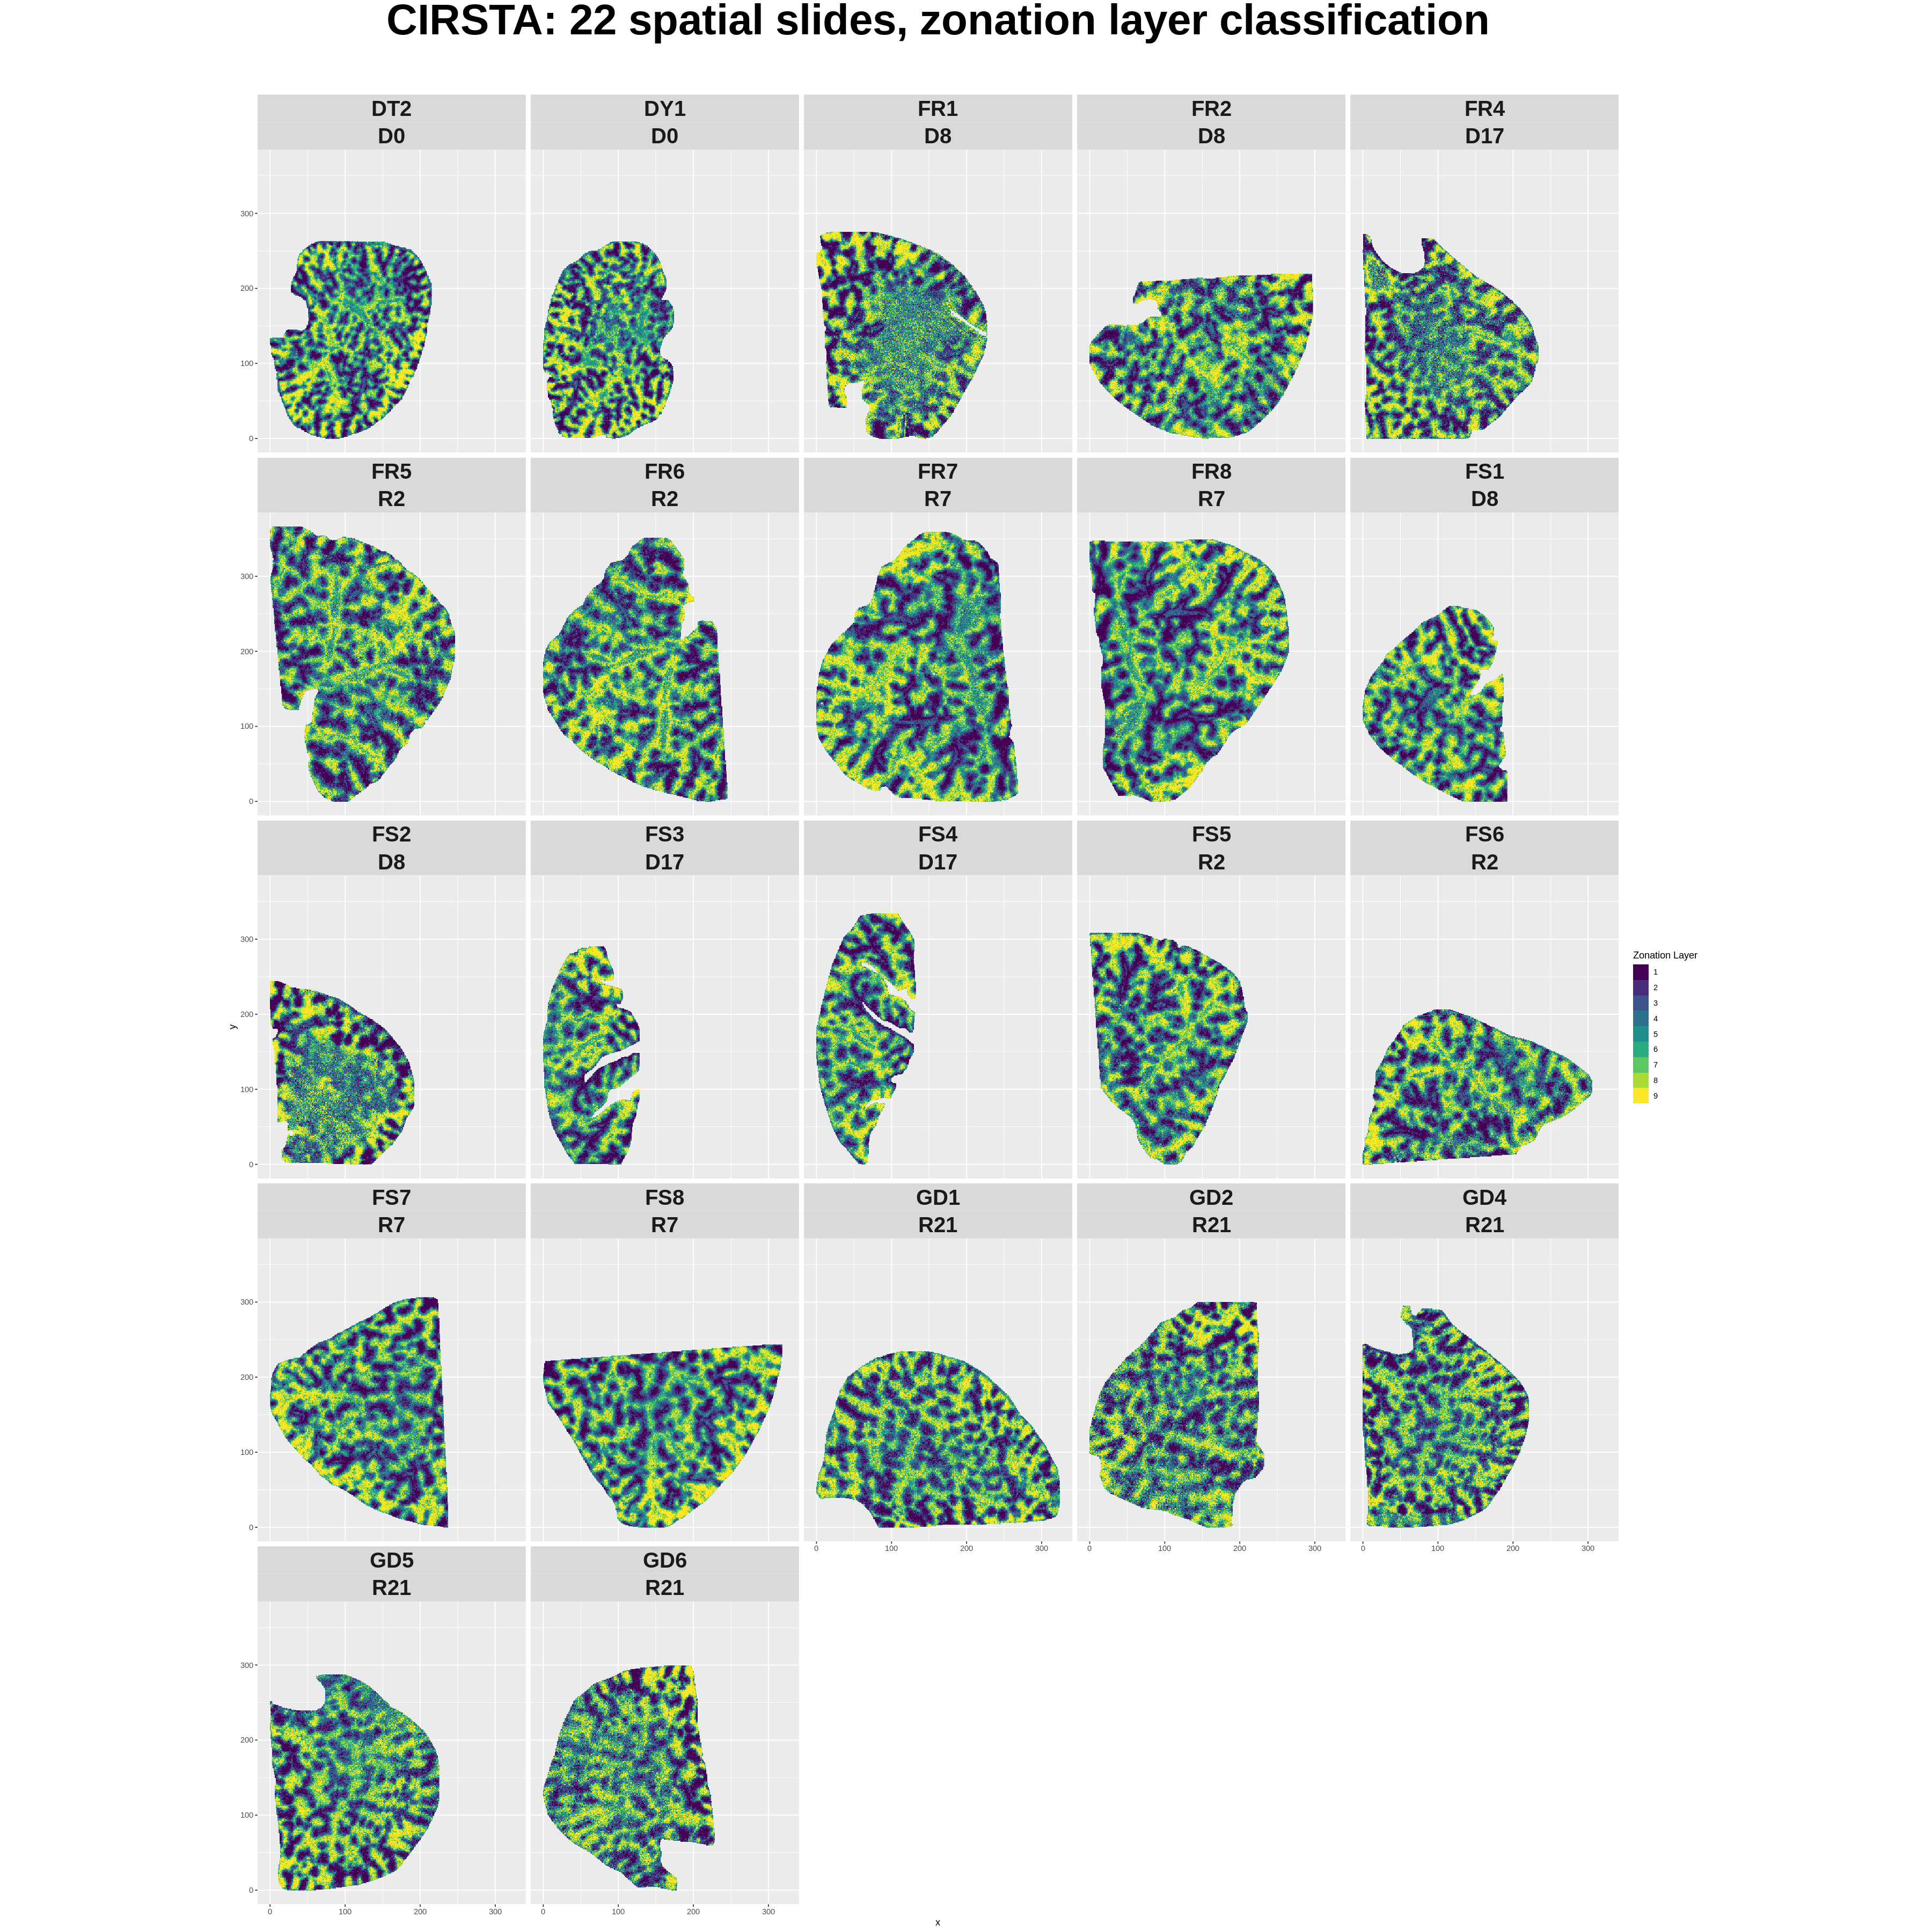

In [54]:
options(repr.plot.width = 5*6, repr.plot.height = 5*6)
ggplot(data = sp@meta.data, aes(x, y)) +
geom_raster( aes(fill = factor(rank)) ) +
coord_fixed() +
scale_fill_manual(values = viridisLite::viridis(n = 9)) +
facet_wrap(~slide+time) +
labs(title = "CIRSTA: 22 spatial slides, zonation layer classification\n", fill = "Zonation Layer") +
theme(
    plot.title = element_text(size = 48, hjust = 1/2.0, face = "bold"), 
    strip.text = element_text(size = 24, hjust = 1/2.0, face = "bold")
     )

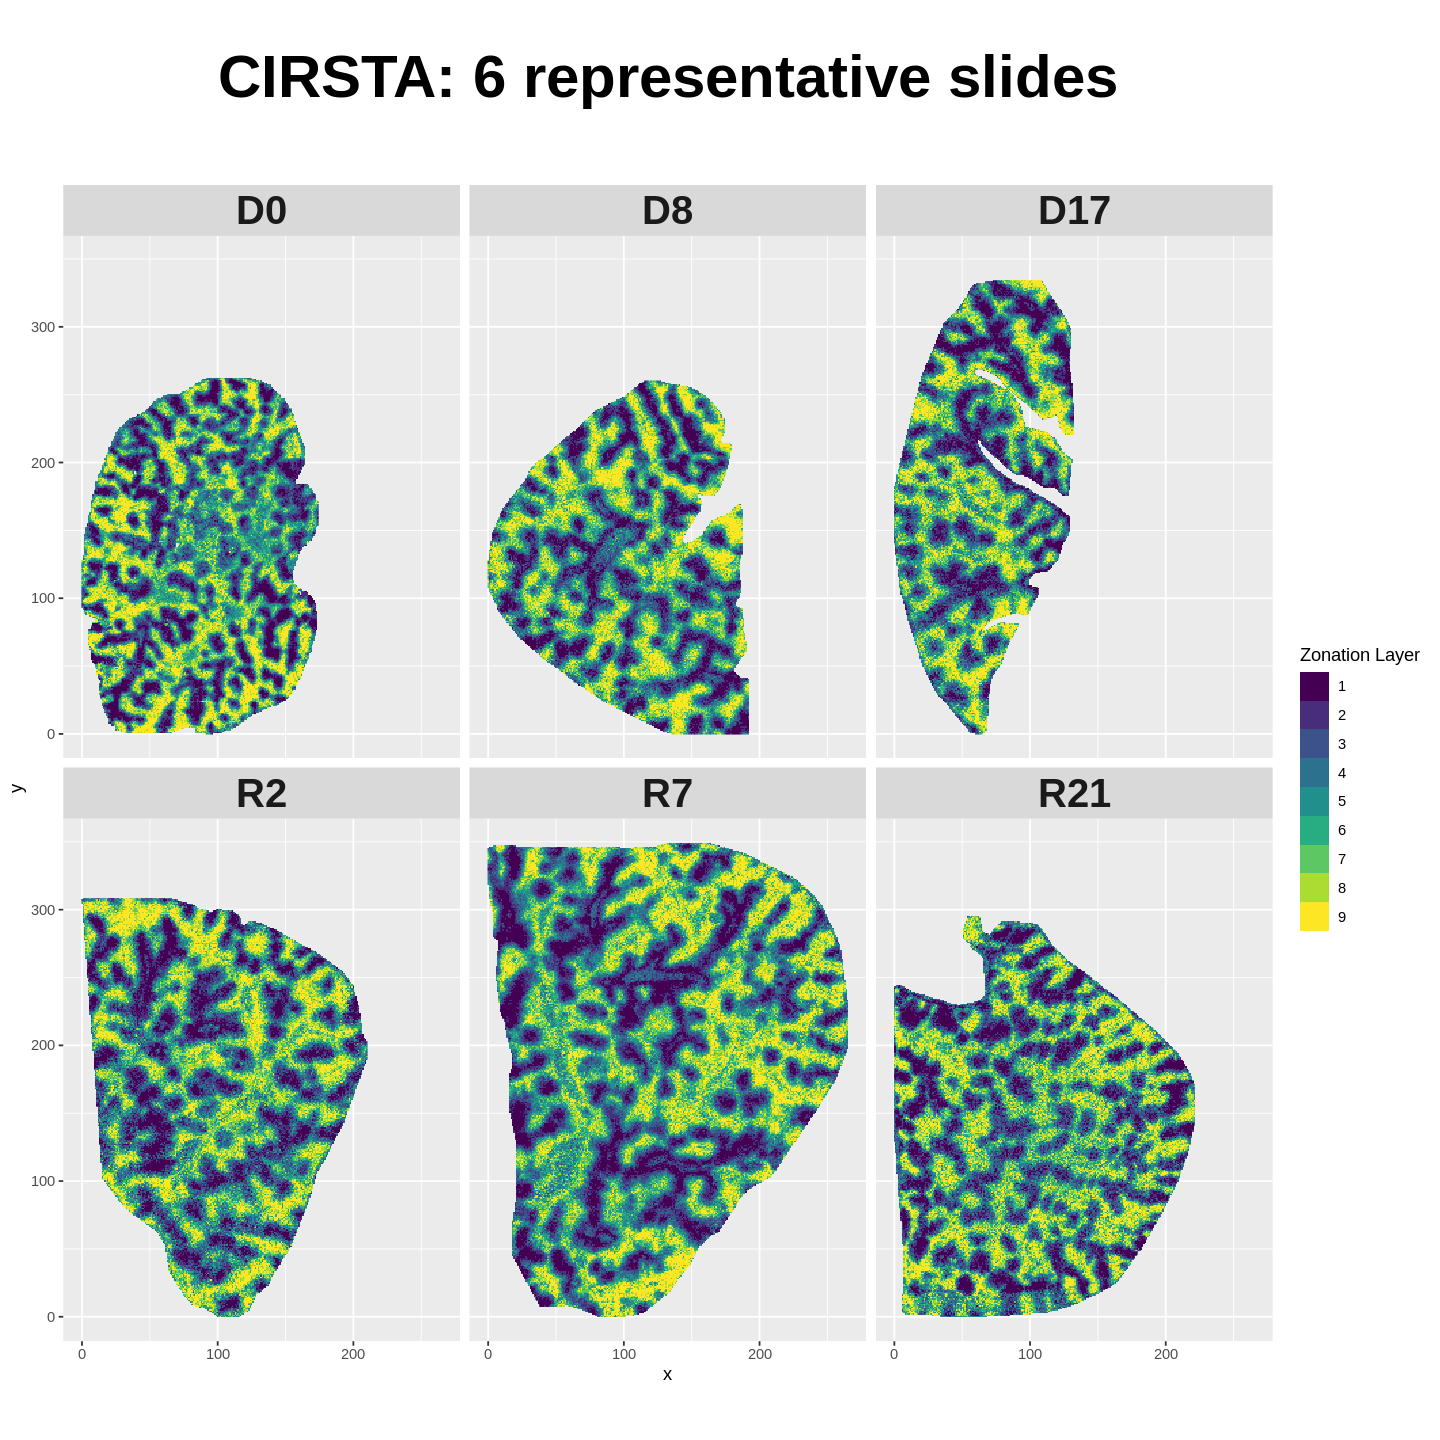

In [53]:
options(repr.plot.width = 2*6, repr.plot.height = 2*6)
ggplot(data = filter( sp@meta.data, slide %in% representative_slides), aes(x, y)) +
geom_raster(aes(fill = factor(rank))) +
coord_fixed() +
scale_fill_manual(values = viridisLite::viridis(n = 9)) +
facet_wrap(~time) +
labs(title = "CIRSTA: 6 representative slides\n", fill = "Zonation Layer") +
theme(
    plot.title = element_text(size = 36, hjust = 1/2.0, face = "bold"), 
    strip.text = element_text(size = 24, hjust = 1/2.0, face = "bold")
     )

# MAGIC imputation

[MAGIC R version](https://github.com/KrishnaswamyLab/MAGIC) is used to denoising high-dimensional data for *in situ* visualization of Stereo-seq gene expression. To save computing resources, we imputed genes which are listed in [celltalkDB::mouse_lr_pair.txt](http://tcm.zju.edu.cn/celltalkdb/download.php).

Noted that this imputated data is supposed to used for data visualization instead of any statistics analysis.

In [ ]:
library("Rmagic")
library("phateR")

In [ ]:
celltalkDB_genes <- read.table("celltalkDB_mouse_lr_pair.txt", sep = "\t", header = TRUE)
celltalkDB_genes <- unique( celltalkDB_genes$ligand_gene_symbol, celltalkDB_genes$receptor_gene_symbol )

In [ ]:
expr <- Seurat::GetAssayData(sp)
expr <- expr[ rownames(expr) %in% celltalkDB_genes, rownames(sp@meta.data)[sp@meta.data$slide %in% representative_slides] ]

# run MAGIC
sp_MAGIC <- magic(expr, genes = "all_genes")$result

In [4]:
sp_MAGIC <- readRDS("CIRSTA_spatial_magic.rds")$result

In [6]:
sp_MAGIC[1:3, 1:3]

Wnt3         Wnt9a       Fgf23       
8D-M2-1_FS1_199_114 1.805732e-05 0.003828286 1.395649e-05
8D-M2-1_FS1_199_119 2.652077e-05 0.005219698 4.868716e-04
8D-M2-1_FS1_199_124 5.458309e-05 0.013976449 2.119490e-05

In [125]:
MagicMap_plotter <- function (
    gene,
    meta,
    magic,
    lines = FALSE,
    nrow = 1,
    ncol = 6,
    line_width = 0.8,
    facet = FALSE,
    rescale = FALSE)
{
    if (!gene %in% colnames(magic)) {
        cat("The gene: ", gene, " is not listed in MAGIC object! Quit.\n")
        return()
    }
    require("ggplot2")
    require("dplyr")
    
    times <- c("D0", "D8", "D17", "R2", "R7", "R21")
    df <- meta[ rownames(magic) , c("x", "y", "time", "rank", "slide")]
    df$value <- magic[, gene] # single gene
    
    if (rescale) {
        p <- df %>% ggplot(aes(x, y)) + geom_raster(aes(fill = scales::rescale(value)))
    }
    else {
        p <- df %>% ggplot(aes(x, y)) + geom_raster(aes(fill = value))
    }
    
    # Basic ggplot2
    p <- p + 
        scale_fill_viridis_c(option = "B", direction = -1) + 
        annotate("segment", x = 0, xend = 4*5, y = -10, yend = -10, size = 2, colour = "black") + 
        annotate("text", x = 4*5+1, y = -20, label = c("500 um"))
    
    if (lines) {
        p <- p + 
#         geom_contour(aes(z = rank), 
#                      breaks = 5, color = "white", size = line_width + 1, 
#                      lineend = "round", linejoin = "round") + 
        geom_contour(aes(z = rank), breaks = 5, color = "black", size = line_width, 
                     lineend = "round", linejoin = "round")
    }
    # Add scale legends on spatial visualizations
    p <- p + 
        annotate("segment", x = 0, xend = 4*5, y = -10, yend = -10, size = 2, colour = "black") + 
        annotate("text", x = 4*5+1, y = -20, label = c("500 um")) + 
        coord_fixed() + 
        labs(fill = "Magic_value", title = gene)
    
    if (facet) {
        p <- p + facet_wrap(~time, ncol = ncol, nrow = nrow)
    }
    
    # Fill legend position
    p <- p + 
        theme(
            legend.position = "bottom", 
            plot.title = element_text(face = "italic", hjust = 0.5, size = 24)
        ) + 
    guides(fill = guide_colorbar(ticks.colour = NA))
    
    return(p)
}

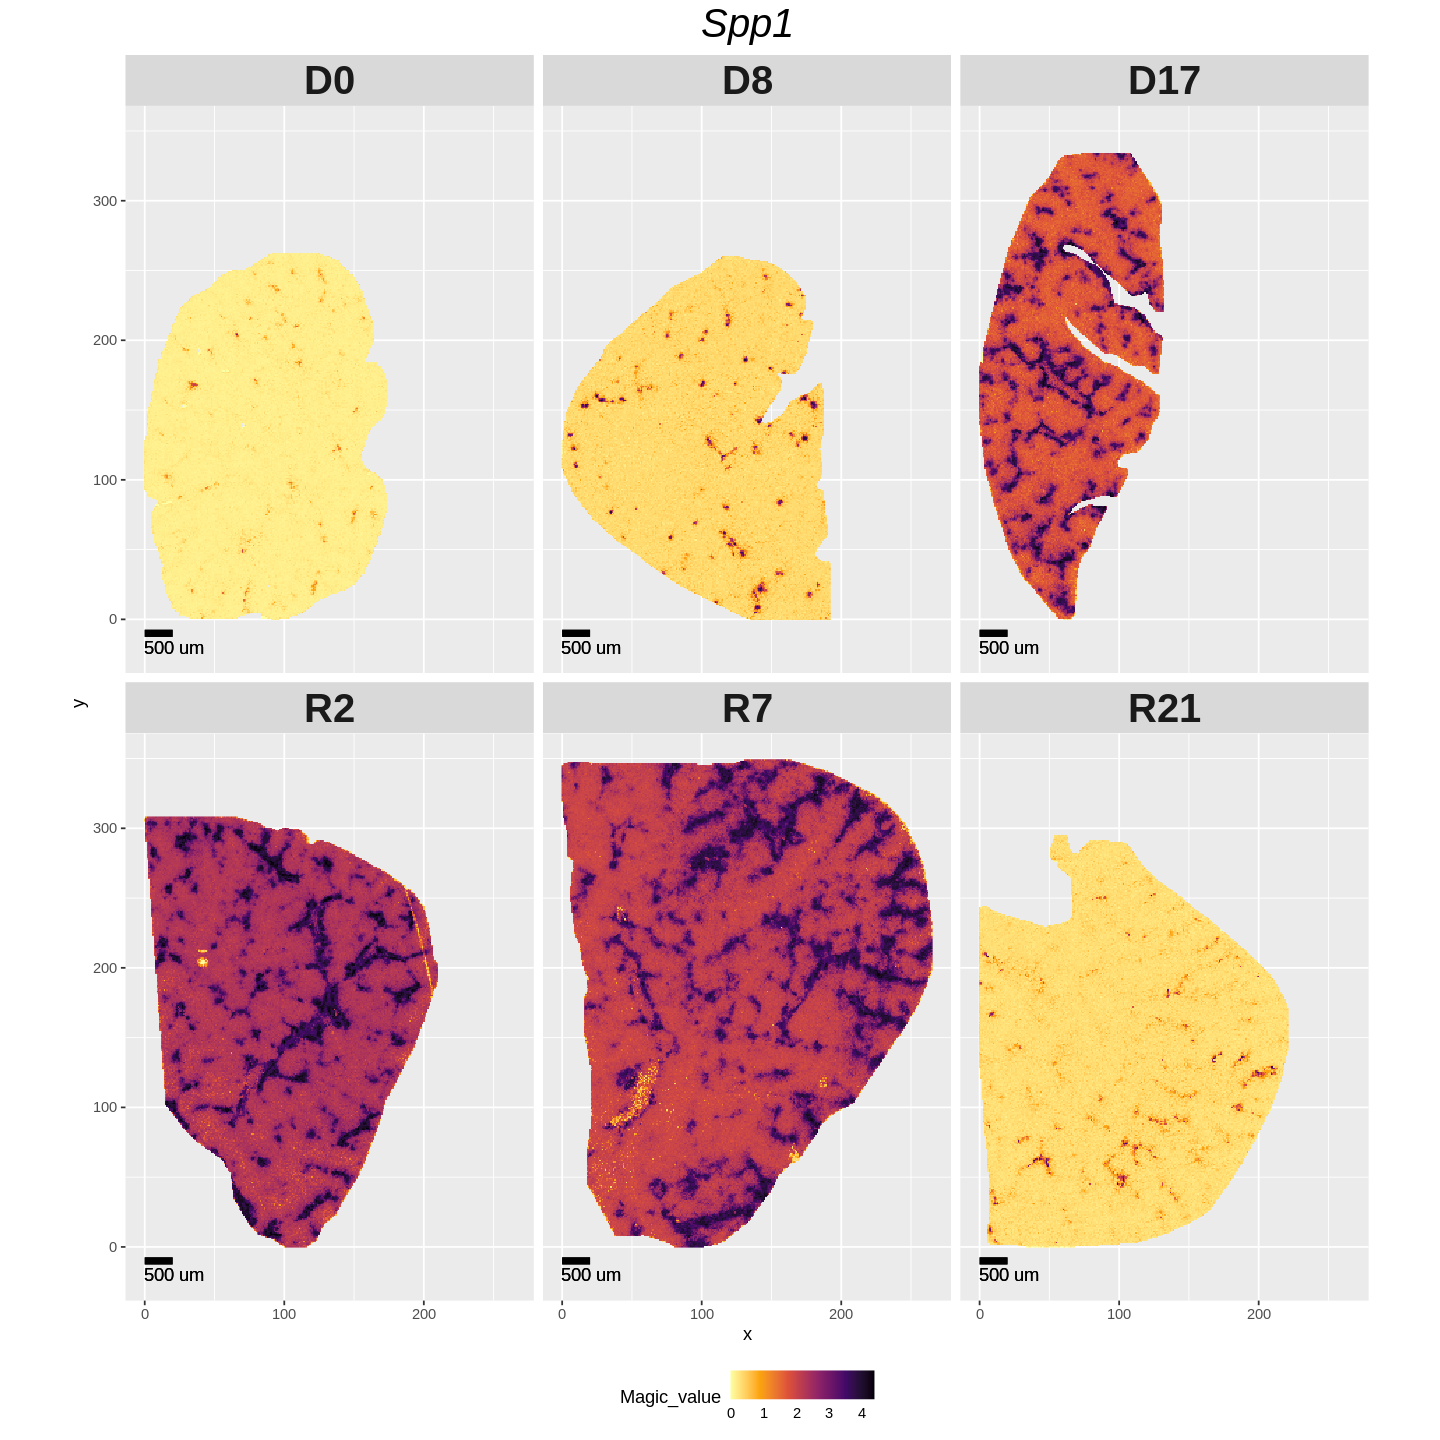

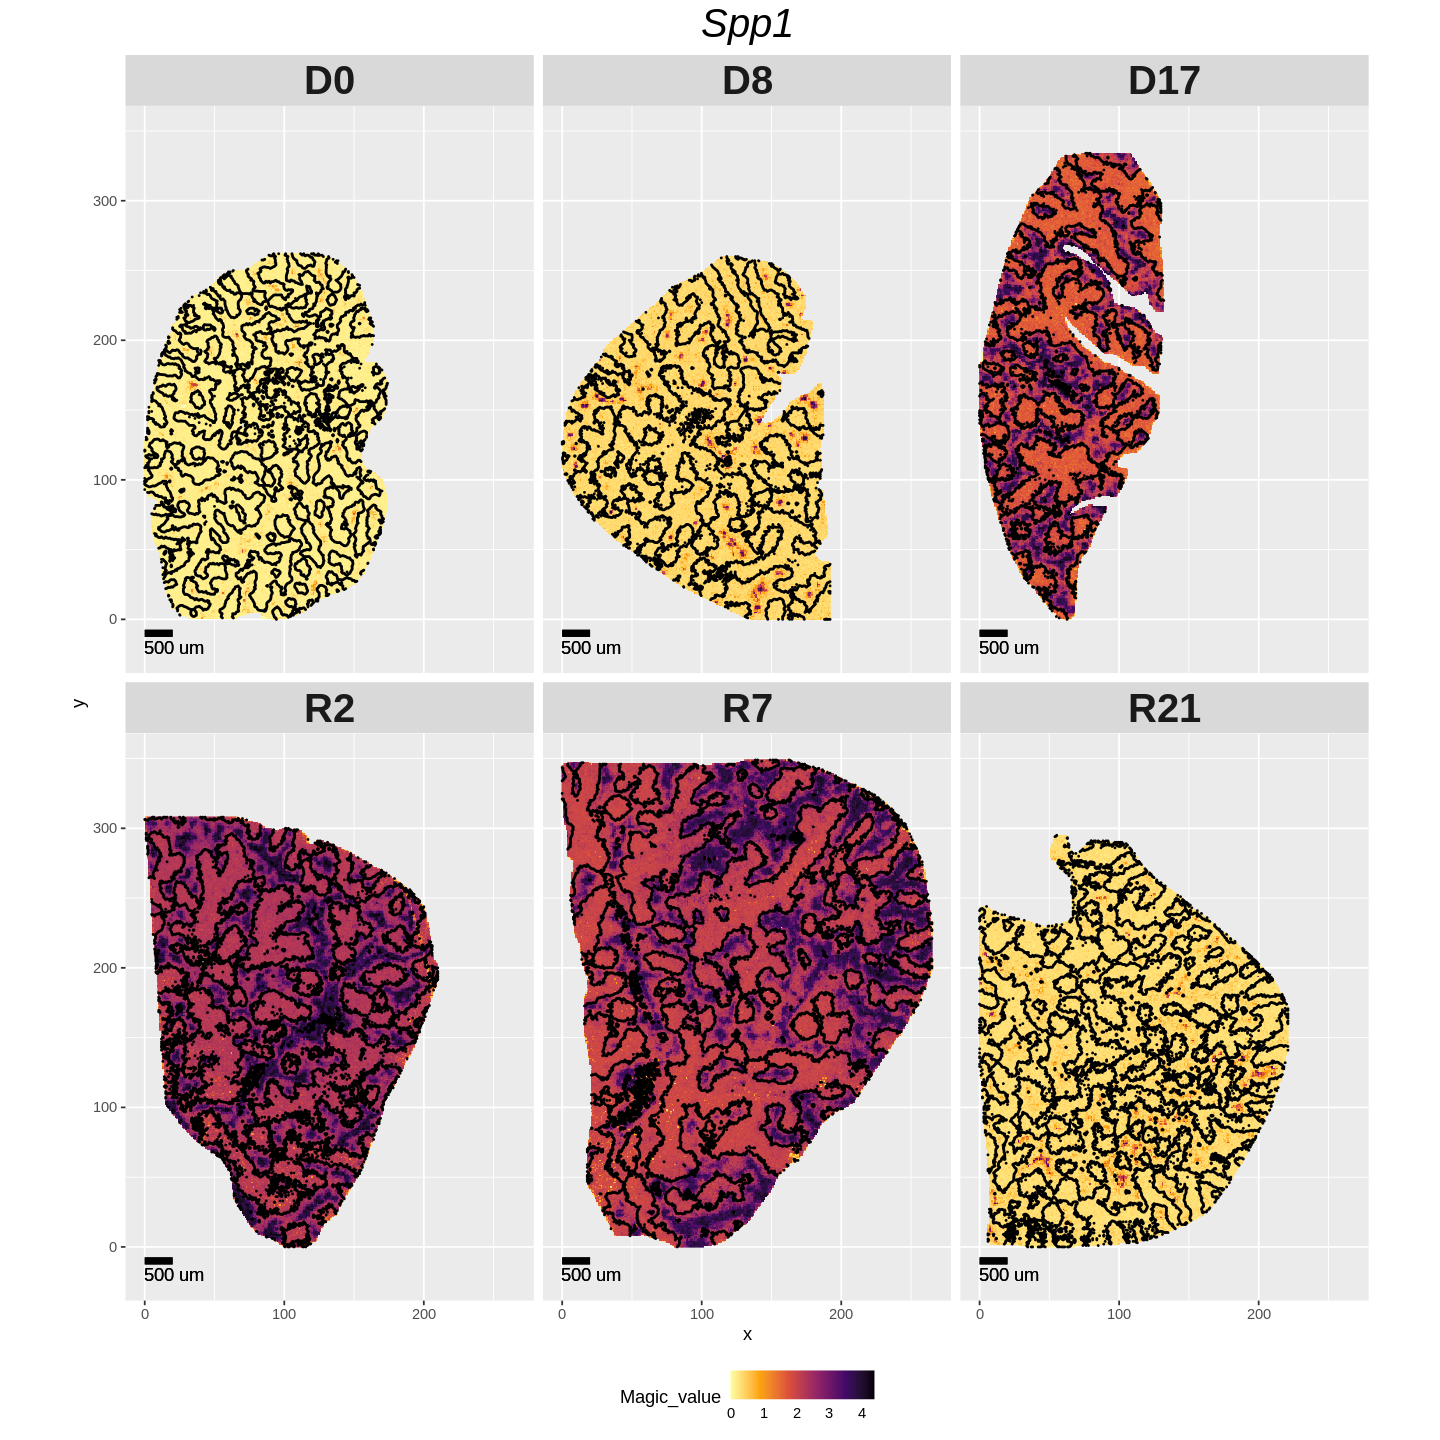

In [126]:
options(repr.plot.width = 2*6, repr.plot.height = 2*6)

for (g in c("Spp1")) {
    p <- MagicMap_plotter(gene = g, meta = meta, magic = sp_MAGIC, facet = TRUE, nrow = 2, ncol = 3) + 
        theme(strip.text = element_text(size = 24, hjust = 1/2.0, face = "bold"))
    
    plot(p)
    
    p <- MagicMap_plotter(gene = g, meta = meta, magic = sp_MAGIC, facet = TRUE, nrow = 2, ncol = 3, lines = TRUE) + 
        theme(strip.text = element_text(size = 24, hjust = 1/2.0, face = "bold"))
    plot(p)
}

# Spatial visualization Ligand-Receptor interaction

Here, we took Ligand x Receptor multiplying product as the interaction strength. 

Noted that the result by Magic imputation is only for data visualization.

In [45]:
LR_MAGIC_multpler <- function(LRlists, meta, magic, return.zonationMean = FALSE) {
    require("dplyr")
    # Intialization
    data <- magic
    meta <- meta[rownames(data),]
    times <- c("D0", "D8", "D17", "R2", "R7", "R21")
    
    # Extract gene(from given LR gene lists) Matrix
    LRmember.list <- strsplit(LRlists, "_") %>% unlist %>% unique
    LRmember.list <- LRmember.list[ LRmember.list %in% colnames(data) ]
    LRmember.matrix <- data[, LRmember.list]
    
    # Generate Ligand x Receptor Matrix
    LRpairs.matrix <- Matrix::Matrix(0, 
                                         nrow = nrow(LRmember.matrix),
                                         ncol = length(LRlists)
                                        )
    colnames(LRpairs.matrix) <- LRlists
    rownames(LRpairs.matrix) <- rownames(LRmember.matrix)
    
    # Filling the Ligand x Receptor Matrix
    for (LR in colnames(LRpairs.matrix)) {
        LRwho <- strsplit(LR, "_") %>% unlist
        LRpairs.matrix[, LR] <- LRmember.matrix[rownames(LRpairs.matrix), LRwho[1] ] * LRmember.matrix[ rownames(LRpairs.matrix), LRwho[2] ]
    }
    
    if (return.zonationMean) {
        # Construct the downstreaming Matrix, 
        # calculating the mean Ligand x Receptor strength in each layer per time point
        ranks.df <- Matrix::Matrix(0, nrow = length(LRlists), ncol = 54)
        colnames(ranks.df) <- paste(rep(times, each = 9), "layer", c(1:9), sep = "_");
        rownames(ranks.df) <- LRlists
        # Mean value
        for (time in 1:length(times)) {
            time.meta <- meta[meta$time == times[time],]

            for (rank in c(1:9)) {
                rank.time.meta <- time.meta[time.meta$rank == rank,]
                bins <- rownames(rank.time.meta)
                bins.LRpairs.matrix <- LRpairs.matrix[bins,]

                ranks.df[, ((time-1)*9 + rank)] <- apply(bins.LRpairs.matrix, 2, mean)
            }
        }
        
        return(list(matrix = LRpairs.matrix, meta = meta, LRs = colnames(LRpairs.matrix), ranks.df = ranks.df))
    } else {
        return(list(matrix = LRpairs.matrix, meta = meta, LRs = colnames(LRpairs.matrix)))
    }
}

In [42]:
LxR_magic <- LR_MAGIC_multpler(LRlists = c("Postn_Egfr", "Igf2_Igf2r", "Sfrp1_Fzd2"), 
                            meta = sp@meta, 
                            magic = sp_magic, return.zonationMean = FALSE)

In [78]:
lapply(LxR_magic, FUN = head)

$matrix
6 x 3 sparse Matrix of class "dgCMatrix"
                    Postn_Egfr   Igf2_Igf2r   Sfrp1_Fzd2
8D-M2-1_FS1_199_114 0.03018853 1.674052e-04 5.472309e-06
8D-M2-1_FS1_199_119 0.04334311 4.835939e-05 1.296843e-06
8D-M2-1_FS1_199_124 0.03419987 5.957756e-05 4.453803e-06
8D-M2-1_FS1_199_111 0.02883331 1.127381e-04 3.040842e-06
8D-M2-1_FS1_199_117 0.03526422 1.332382e-04 3.188070e-06
8D-M2-1_FS1_199_129 0.02644321 3.491397e-04 7.043563e-06

$meta
                    nCount_RNA nFeature_RNA percent.mt      sample slide time
8D-M2-1_FS1_199_114       5507         1318  1.2711095 8D-M2-1_FS1   FS1   D8
8D-M2-1_FS1_199_119       5559         1380  1.0073754 8D-M2-1_FS1   FS1   D8
8D-M2-1_FS1_199_124       5875         1485  0.8340426 8D-M2-1_FS1   FS1   D8
8D-M2-1_FS1_199_111       5453         1341  1.0452962 8D-M2-1_FS1   FS1   D8
8D-M2-1_FS1_199_117       6160         1513  1.2337662 8D-M2-1_FS1   FS1   D8
8D-M2-1_FS1_199_129       6434         1535  1.1656823 8D-M2-1_FS1   FS1   D8

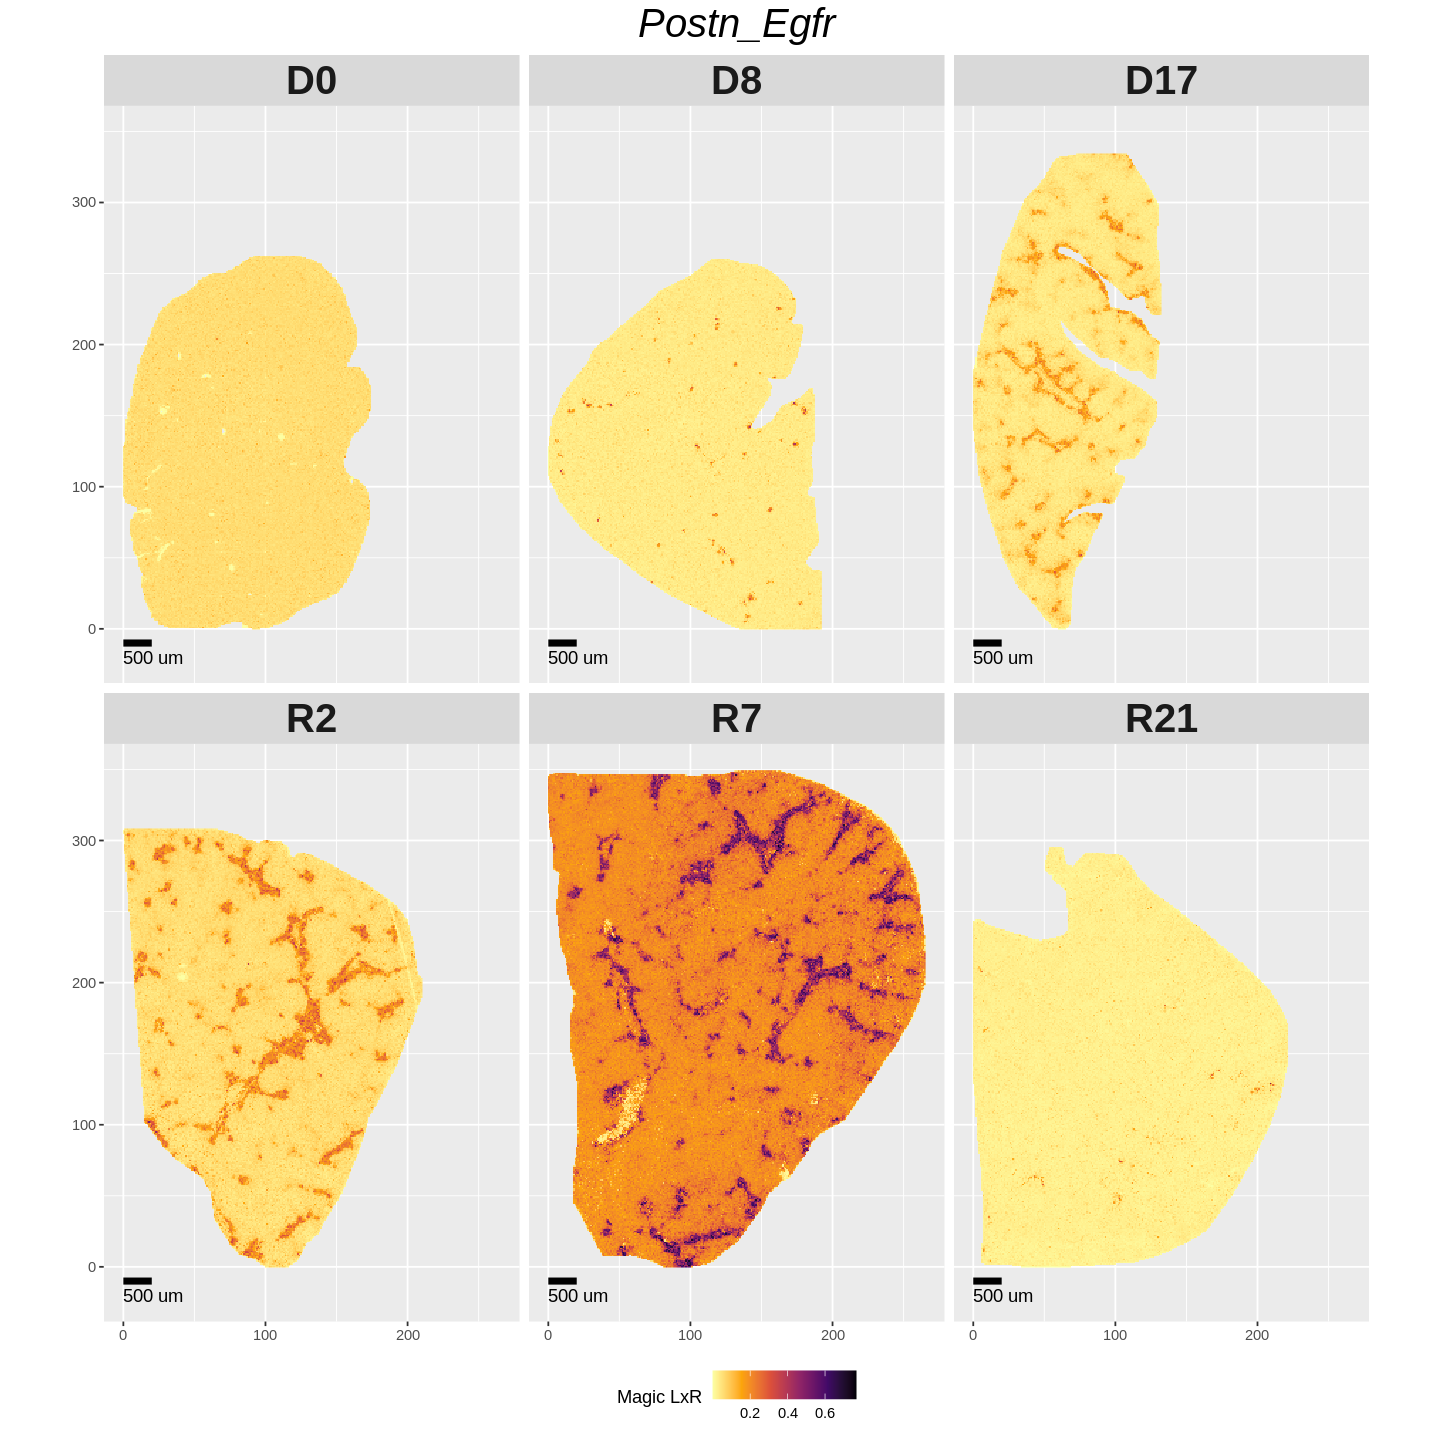

In [75]:
df <- LxR_magic$meta
df$value <- LxR_magic$matrix[ rownames(df), "Postn_Egfr"]

p <- ggplot(data = df, aes(x = x, y = y)) +
geom_raster(aes(fill = value)) +
scale_fill_viridis_c(option = "B", direction = -1) + 
coord_fixed() +
labs(x = NULL, y = NULL, fill = "Magic LxR", title = "Postn_Egfr") +
annotate("segment", x = 0, xend = 4*5, y = -10, yend = -10, size = 2, colour = "black") + 
annotate("text", x = 4*5+1, y = -20, label = c("500 um")) +
facet_wrap(~time) +
theme(plot.title = element_text(face = "italic", size = 24, hjust = 1/2),
      strip.text = element_text(size = 24, hjust = 1/2.0, face = "bold"),
      legend.position = "bottom"
     )

options(repr.plot.width = 2*6, repr.plot.height = 2*6)
p

# Cell type deconvolution on spatial

To deconvolute cell type on spatial slides, we used RCTD([Cable, Dylan M., et al., *Nature Biotechnology*, 2022](https://doi.org/10.1038/s41587-021-00830-w)) from [spacexr](https://github.com/dmcable/spacexr).

Here, we take the D17 representative slide as an example.

## run RCTD

In [ ]:
library("spacexr")

load_singleCellRef <- function(sc_path) {
    # Load scRNA annotated data, SeuratObj
    sc <- readRDS(file = sc_path)
    sc$type <- Idents(sc)
    
    # Extract counts matrix and meta info
    counts <- sc@assays$RNA@counts
    meta_data <- sc@meta.data
    
    cell_types <- meta_data$type
    names(cell_types) <- rownames(meta_data)
    cell_types <- as.factor(cell_types)
    
    nUMI <- meta_data$nCount_RNA
    names(nUMI) <- rownames(meta_data)
    
    # Return
    reference <- spacexr::Reference(counts, cell_types, nUMI)
    return(reference)
}

load_spatialRef <- function(spatial_path) {
    # Load spatial data, SeuratObj
    spatial <- readRDS(spatial_path)
    
    # Extract counts matrix
    counts <- spatial@assays$RNA@counts
    
    # Extract spatial coordinates
    coords <- spatial@meta.data[, c("x", "y")]
    nUMI <- colSums(counts)
    
    puck <- spacexr::SpatialRNA(coords, counts, nUMI)
    
    return(puck)
}

In [ ]:
reference <- load_ref("path_to_D17_scRNA_anotated_seuratObj.rds")
puck <- load_spatial("path_to_D17_representative_spatial_slide_seuratObj.rds")

RCTD_D17 <- spacexr::create.RCTD(puck, reference, max_cores = 8, CELL_MIN_INSTANCE = 10)
RCTD_D17 <- spacexr::run.RCTD(myRCTD, doublet_mode = "doublet")

## Cell distribution on spatial

In [77]:
RCTD_preprocessor <- function(RCTD_result, mask) {
    
    # `mask` is the cell types which were not show on spatial
    mask_default <- c("Endo")
    if (missing(mask)) {
        mask = mask_default
    } else {
        mask = c(mask_default, mask)
    }
    
    # The dependency functions
    ## FUNCTION: Extract weights Matrix from a given RCTD_result
    extractWeight <- function(dat) {
        return(Matrix::Matrix(RCTD_result@results$weights, sparse = TRUE))
    }
    ## FUNCTION: K-Means filter by celltype for weights Matrix, to judge if a celltype in a spatial bin50
    kmeanFilter <- function(weights, cores = 2, nn = 1) {
        kmFilter_results <- apply(weights, 2, function(x) {
            x_kmeans <- kmeans(x = x, centers = cores)
            res <- x_kmeans$cluster; name <- names(res)
            
            toRestore <- head(x = order(x_kmeans$centers, decreasing = TRUE), n = nn)
            res <- as.integer(res %in% toRestore)
            names(res) <- name
            return(res)
        })
        
        return(as.data.frame(kmFilter_results))
    }
    

    weights.df <- extractWeight(RCTD_result)
    
    kmeans.df1 <- kmeanFilter(weights.df)
    ## For HSC celltype, we apply 4 cores in k-means and take 2 biggest clusters
    kmeans.df2 <- kmeanFilter(weights.df, cores = 4, nn = 2)
    kmeans.df <- kmeans.df1; kmeans.df[, "HSC"] <- kmeans.df2[ rownames(kmeans.df), "HSC"]
    
    npc_rank <- apply(kmeans.df, 2, sum) %>%
        sort(decreasing = TRUE) %>%
        names()
    npc_rank <- npc_rank[!npc_rank %in% mask]
    
    # Generate data.frame restoring spatial bins coordinates and cell type
    for (i in npc_rank) {
        if (i == npc_rank[1]) {
            tmp.df <- cbind(RCTD_result@spatialRNA@coords[rownames(kmeans.df)[kmeans.df[,
                i] == 1], ], 
                            weights.df[kmeans.df[, i] == 1, i], 
                            i)
            tmp.df <- cbind(tmp.df, bin = rownames(tmp.df))
            rownames(tmp.df) <- NULL
        } else {
            tmp2.df <- cbind(RCTD_result@spatialRNA@coords[rownames(kmeans.df)[kmeans.df[,
                i] == 1], ], weights.df[kmeans.df[, i] == 1, i], i)
            tmp2.df <- cbind(tmp2.df, bin = rownames(tmp2.df))
            tmp.df <- rbind(tmp.df, tmp2.df)
        }
    }
    
    colnames(tmp.df) <- c("x", "y", "weights", "type", "bin")
    tmp.df$size <- 1
    tmp.df$size[which(tmp.df$type == "KC")] <- 0.1
    tmp.df$x <- tmp.df$x - min(tmp.df$x)
    tmp.df$y <- tmp.df$y - min(tmp.df$y)
    

    coords <- RCTD_result@spatialRNA@coords
    coords$x <- coords$x - min(coords$x)
    coords$y <- coords$y - min(coords$y)

    LPLC_cor <- coords[weights.df[kmeans.df$LPLC == 1, "LPLC"][weights.df[kmeans.df$LPLC == 1, "LPLC"] >= median(weights.df[kmeans.df$LPLC ==
            1, "LPLC"])] %>% names(), ]

    return(list(npc.df = tmp.df, coor = coords, LPLC_cor = LPLC_cor))
}

Warning message:
“Raster pixels are placed at uneven vertical intervals and will be shifted. Consider using geom_tile() instead.”


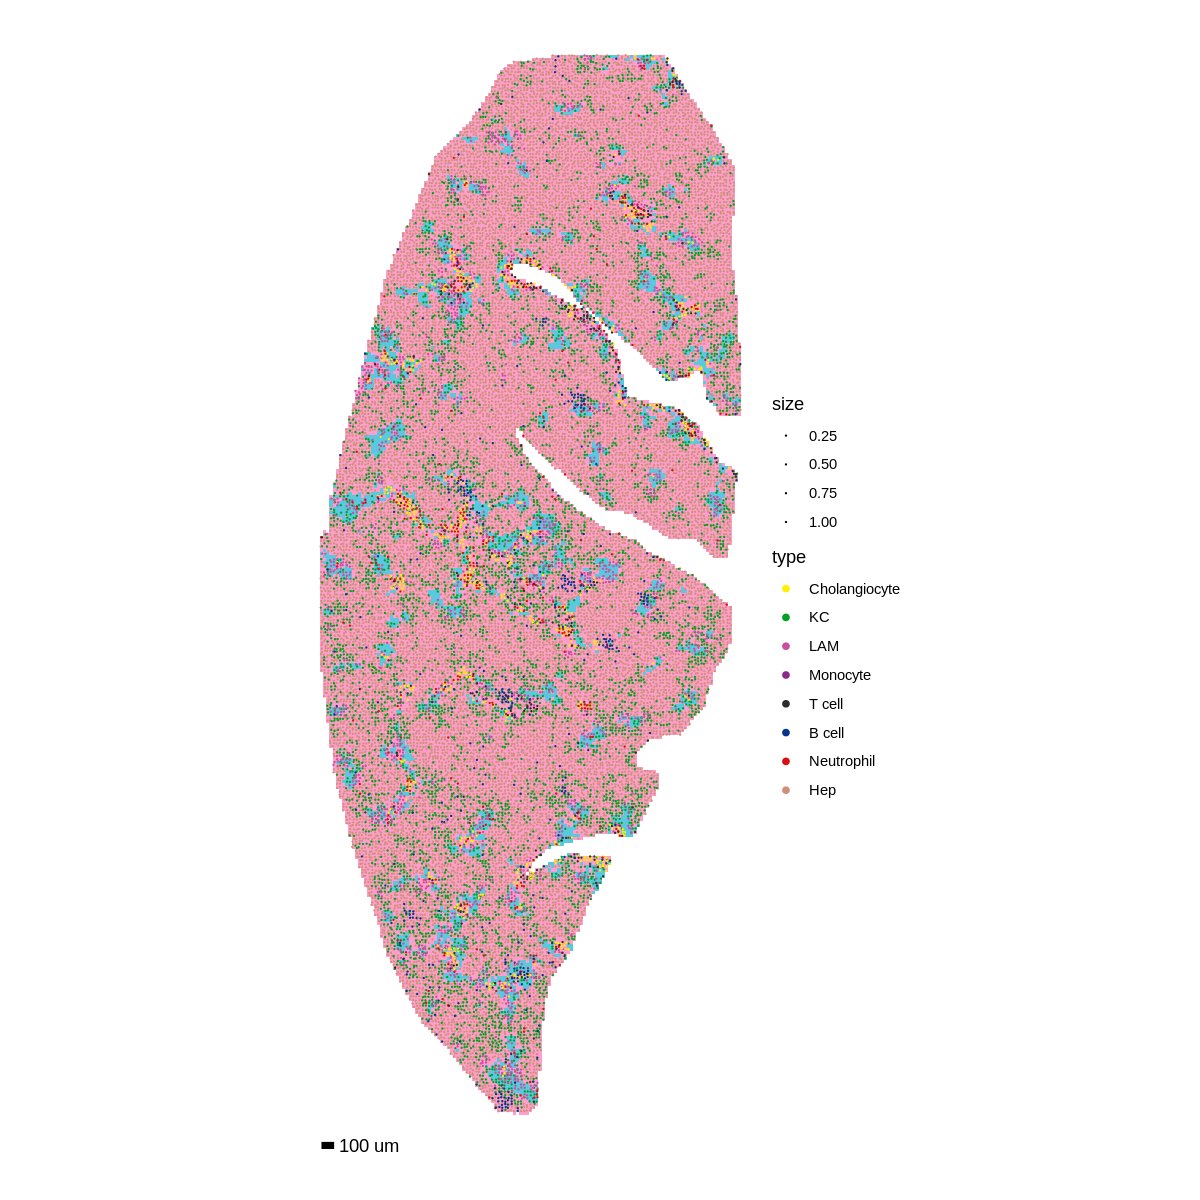

In [81]:
index <- c("Cholangiocyte", "KC", "LAM", "Mono", "T cell", "B cell", "Neutrophil", "Hep")
# Palette
palette <- c(`Cholangiocyte` = "#ffef00", `KC` = "#00a120",  `LAM` = "#c8509b",  `Monocyte` = "#8d278a", 
          `T cell` = "#2c2c2c", `B cell` = "#073290", `Neutrophil` = "#d90e11", `Hep` = "#ce9178")

tmp <- RCTD_preprocessor(RCTD_result = RCTD_D17)
npc_df <- dplyr::filter(tmp$npc.df, type %in% index)
coor <- tmp$coor
LPLC_cor <- tmp$LPLC_cor

# Flip the D17 slide for better visualization
coor[, c("x", "y")] <- coor[, c("y", "x")]
LPLC_cor[, c("x", "y")] <- LPLC_cor[, c("y", "x")]
npc_df[, c("x", "y")] <- npc_df[, c("y", "x")]

# Start plotting
## Layer: Tissue area
p <- ggplot(coor, aes(x = x, y = y)) + 
    geom_raster(fill = "#ff9ecd") + 
    coord_fixed()
## Layer: LPLC area, calculated based on RCTD_result
p <- p + 
    geom_raster(data = LPLC_cor, mapping = aes(x, y), fill = "#5ac8df", show.legend = FALSE)
## Layer: celltype point
p <- p +
    geom_point(data = npc_df, mapping = aes(x, y, color = type, size = size),
               position = position_jitter(h = 0.3, w = 0.3),
               show.legend = TRUE
              ) +
    scale_size_area(max_size = 0.005) +
    scale_color_manual(values = palette)
# Layer: scale size
p <- p +
    annotate("segment", x = 0, xend = 4, y = -10, yend = -10, size = 2, colour = "black") + 
    annotate("text", x = 15, y = -10, label = c("100 um")) + 
    theme_void()

options(repr.plot.width = 10, repr.plot.height = 10)
p

# Module score calculation

The module score of a celltype signatures / pathway signaling / biological process is calculated by `Seurat::AddModuleScore()`

```r
library("Seurat")

sp <- Seurat::AddModuleScore(object = sp, 
                             features = list(geneset_1 = c("gene_A", "gene_B", "gene_C")), 
                             name = "geneset_1")
```

In [118]:
toshow <- c("Oxidative_stress", "DNA_damage", "Inflammation", "DAMP", 'Cellular_senescence', 'ECM_organization')
times <- c("D0", "D8", "D17", "R2", "R7", "R21")

df <- sp@meta.data[, c("time", "rank",toshow)]
df$index <- paste(df$time, "_layer_", df$rank, sep = "")
df$index <- factor(df$index, 
                   levels = paste(rep(times, each = 9), "_layer_", rep(c(1:9), times = 6), sep = "")
                  )
df[, c("time", "rank")] <- NULL

df <- df %>% group_by(index) %>% summarise_all(.funs = mean) %>% as.data.frame()
rownames(df) <- df$index; df$index <- NULL
df <- t(df)

anno_col <- data.frame(time = factor(x = lapply(strsplit(colnames(df), split = "_layer_"), 
                                                FUN = function(x) {return(x[1])}), 
                                     levels = times), 
                       row.names = colnames(df))

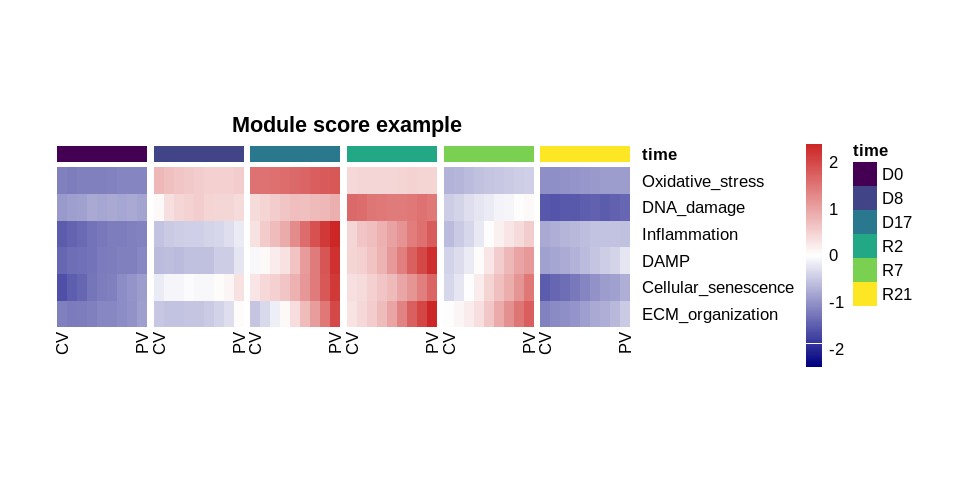

In [123]:
options(repr.plot.width = 8, repr.plot.height = 4)
ann_col_colors <- list(time = viridisLite::viridis(n = 6))
names(ann_col_colors$time) <- c("D0", "D8", "D17", "R2", "R7", "R21")

p <- pheatmap::pheatmap(df, 
                        scale = "row", 
                        angle_col = 90,
                        cluster_rows = FALSE, 
                        cluster_cols = FALSE, 
                        gaps_col = c(1:6) * 9, 
                        labels_col = rep(c("CV", rep("", 7),"PV"), 6), 
                        annotation_col = anno_col, 
                        annotation_colors = ann_col_colors,
                        color = colorRampPalette(c("navy", "white", "firebrick3"))(200), 
                        border_color = NA,
                        cellheight = 16, 
                        cellwidth = 6, 
                        main = "Module score example"
                       ) %>% ggplotify::as.ggplot()

# Gene regulon network

pySCENIC ([Van de Sande B., Flerin C., et al., *Nature Protocols*, 2020](https://doi.org/10.1038/s41596-020-0336-2)) is used to infer GRN and outstanding regulons of CIRSTA spatial data.

The data processing pipeline followed the [pySCENIC tutorial](http://htmlpreview.github.io/?https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/PBMC10k_SCENIC-protocol-CLI.html).

## Data downsampling and format conversion

Regard to the computing limitations, we downsampled the spatial data to 50000 bins each time point.

In Rlang, 

```r
# Convert SeuratObj to h5 by dior (https://github.com/JiekaiLab/dior)
library("dior")

Idents(sp) <- "time"
sampling <- subset(sp, downsample = 50000) # The sum are 300,000 bins

write_h5(sampling, 
         file = "CIRSTA_spatial_downsample_5w.h5", 
         object.type = 'seurat', 
         assay.name = 'RNA')
```

In Python,

```python
# Convert h5 to h5ad by diopy (https://github.com/JiekaiLab/diopy)
import numpy as np
import pandas as pd
import scanpy as sc
import diopy
import h5py

# Convert Successfully
h5 = h5py.File('CIRSTA_spatial_downsample_5w.h5', 'r')
adata = diopy.input.h5_to_adata(h5 = h5, assay_name='RNA')
h5.close()

adata.write_h5ad("CIRSTA_spatial_downsample_5w.h5ad")
```

## run pySENIC

### Data preprocessing for pySENIC

In Python,

```python
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from matplotlib.pyplot import rc_context

adata = sc.read_h5ad("CIRSTA_spatial_downsample_5w.h5ad")

# Total-count normalize (library-size correct) to 10,000 reads/cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# log transform the data.
sc.pp.log1p(adata)

# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# keep only highly variable genes
adata = adata[:, adata.var['highly_variable']]

# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['nCount_RNA', 'percent.mt'])

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(adata, max_value=10)

# PCA step
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

sc.pp.neighbors(adata, n_neighbors=20, n_pcs=30)

# compute UMAP
sc.tl.umap(adata)

f_loom_path_scenic = "CIRSTA_spatial_downsample_5w_hv.loom"

# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}

lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)
```

### STEP 1: Gene regulatory network inference, and generation of co-expression modules

```bash
pyscenic grn CIRSTA_spatial_downsample_5w_hv.loom mm_mgi_tfs.txt -o adj.csv --num_workers 20
```

### STEP 2: Regulon prediction

```bash
pyscenic ctx adj.tsv \
    sources/mm10__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.feather sources/mm10__refseq-r80__10kb_up_and_down_tss.mc9nr.feather \
    --annotations_fname sources/motifs-v9-nr.mgi-m0.001-o0.0.tbl \
    --expression_mtx_fname CIRSTA_spatial_downsample_5w_hv.loom \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 20
```

### STEP 3: Cellular enrichment

```bash
pyscenic aucell \
    CIRSTA_spatial_downsample_5w_hv.loom \
    reg.csv \
    --output CIRSTA_spatial_downsample_5w_hv_output.loom \
    --num_workers 20
```

### Save SCENIC's AUC matrix

```python
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( CIRSTA_spatial_downsample_5w_hv.loom, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

auc_mtx.to_csv("auc_mtx.csv")
```

In [142]:
# AUC visualization
df <- data.table::fread("auc_mtx.csv", stringsAsFactors = TRUE) %>% as.data.frame()
rownames(df) <- df[,1]
df <- df[,-1]
df[1:3, 1:3]

meta_scenic <- sp@meta.data[ rownames(sp@meta.data) %in% rownames(df),]

mtx <- matrix(0, nrow = 6 * 9, ncol = ncol(df))
rownames(mtx) <- paste0(rep(c("D0", "D8", "D17", "R2", "R7", "R21"), each = 9), "_layer_", c(1:9))
colnames(mtx) <- colnames(df)
mtx <- mtx %>% t()

# Mean value of each layer per time point
for (t in c("D0", "D8", "D17", "R2", "R7", "R21")) {
    time.df <- filter(meta_scenic, time == t)

    for (g in rownames(mtx)) {
        time.df$value <- df[rownames(time.df), g]

        r <- time.df %>%
            group_by(rank) %>%
            summarise_each(funs(mean), value) %>%
            ungroup

        mtx[g, paste0(t, "_layer_", r$rank)] <- r$value
    }
}

Atf3_(+)    Atoh8_(+) Bhlhe40_(+)
8D-M2-1_FS1_199_114 0.009810981 0.0000000 0.000000000
8D-M2-1_FS1_199_118 0.010531053 0.1636364 0.005113636
8D-M2-1_FS1_200_114 0.015931593 0.1409091 0.006250000

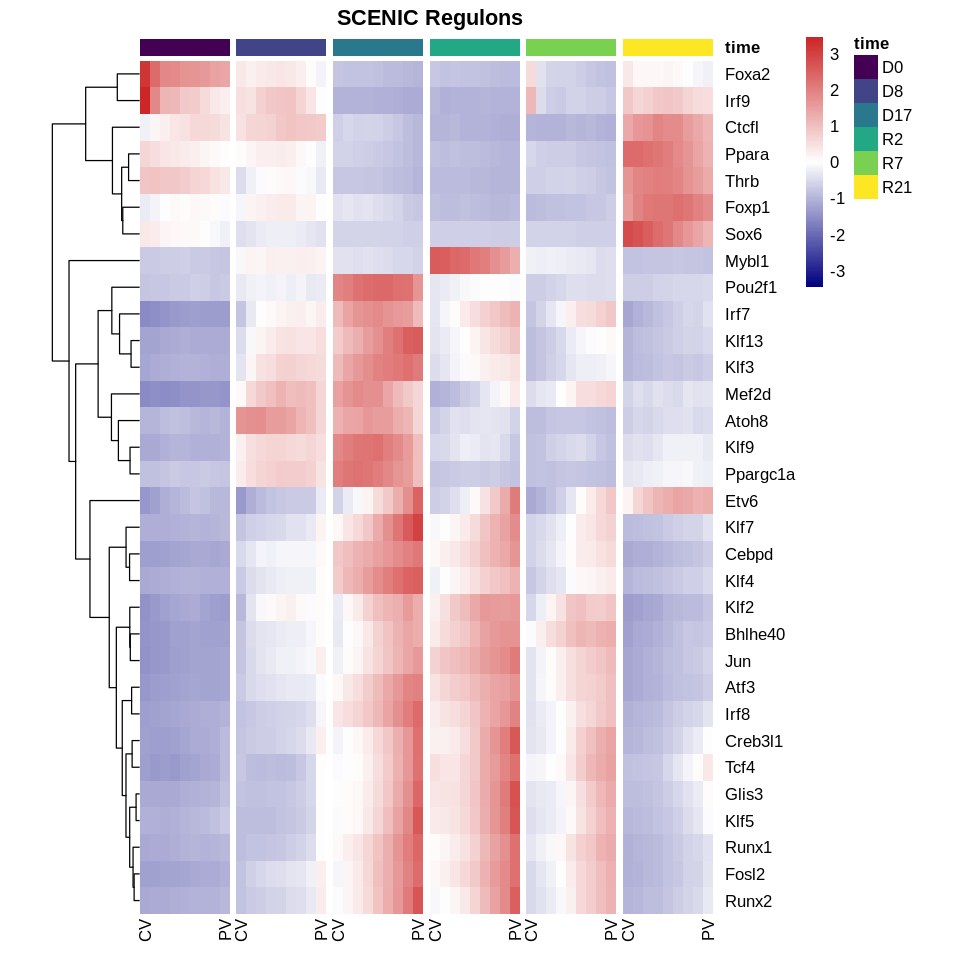

In [143]:
options(repr.plot.width =8, repr.plot.height = 8)

annotation_col <- data.frame(row.names = colnames(mtx), time = rep(c("D0", "D8", "D17", "R2", "R7", "R21"), each = 9))
annotation_col$time <- factor(annotation_col$time, levels = c("D0", "D8", "D17", "R2", "R7", "R21"))
rownames(mtx) <- gsub("_[(+)]*", "", rownames(mtx))

ann_colors <- list(time = viridisLite::viridis(n = 6))
names(ann_colors$time) <- c("D0", "D8", "D17", "R2", "R7", "R21")

ph <- pheatmap::pheatmap(mtx, show_rownames = T, angle_col = 90,
                   cluster_cols = F, scale = "row", 
                   gaps_col = c(1:6) * 9, 
                   labels_col = rep(c("CV", rep("", 7),"PV"), 6), 
                   color = colorRampPalette(c("navy", "white", "firebrick3"))(200), border_color = NA,
                   annotation_col = annotation_col,
                   annotation_colors = ann_colors,
                   cellheight = 16, cellwidth = 6, fontsize = 10, main = "SCENIC Regulons"
                  )

In [144]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server 7.6 (Maipo)

Matrix products: default
BLAS/LAPACK: /sibcb1/huilijianlab1/tuxinyi/miniconda/envs/R/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] spacexr_2.0.0      patchwork_1.1.2    ggplot2_3.3.6      SeuratObject_4.1.3
[5] Seurat_4.3.0       dplyr_1.0.10      

loaded via a namespace (and not attached):
  [1] Rtsne_0.16             colorspace_2.1-0       deldir_1.0-9          
  [4] ellipsis_0.3.2       